In [1]:
import numpy as np
from mindaffectBCI.decoder.offline.datasets import get_dataset
import matplotlib.pyplot as plt
from mindaffectBCI.decoder.analyse_datasets import datasets_GridSearchCV, get_results_per_config
from mindaffectBCI.decoder.utils import askloadsavefile
from mindaffectBCI.decoder.preprocess_transforms import make_preprocess_pipeline
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

## set the parameters for the dataset loader

In [2]:
exptdir = 'Audiometric Threshold/audio_visual_threshold_audio_only_both_ears_5Hz_VID'
loader, filenames, exptdir = get_dataset('mindaffectBCI',exptdir=exptdir)
print("Got {} files".format(len(filenames)))

In [2]:
# ask for a directory to lood all datafiles from
exptdir = askloadsavefile(filetypes='dir')
loader, filenames, exptdir = get_dataset('mindaffectBCI',exptdir=exptdir)
print("Got {} files".format(len(filenames)))

Got 22 files


In [ ]:
loader, filenames, exptdir = get_dataset('twofinger')#brains_on_fire_online') #
print("Got {} files".format(len(filenames)))

In [2]:
loader, filenames, exptdir = get_dataset('lowlands') #plos_one')#
print("Got {} files".format(len(filenames)))

Got 0 files


## set the analysis pipeline

In [3]:
fs_out = 62.5
loader_args = dict(filterband=((.5,45,'bandpass')), fs_out = fs_out)

In [14]:
# cVEP analysis
loader_fs = 120
loader_args = dict(filterband=((.5,45,'bandpass')), fs_out = loader_fs)

artifact_ch=['Fp1', 'Fp2', 'F9', 'F10']
tau_ms=300
rank=1
evtlabs=('re','fe')
temporal_basis='winfourier15'
filterband=[]
fs_out=None

pipeline=[
    'MetaInfoAdder',
    ['BadChannelRemover',{'mode':'zero'}],
    ['NoiseSubspaceDecorrelator', {'ch_names':artifact_ch}],
    ['ButterFilterAndResampler',{'filterband':filter_band, 'fs_out':fs_out}],
    ['TargetEncoder',{'evtlabs':evtlabs}],
    ['MultiCCA:clsfr',{'tau_ms':tau_ms, "rank":rank, "temporal_basis":temporal_basis}],
]

In [4]:
# Audio metric analysis, levels analysis
loader_fs = 62.5
loader_filterband=((.5,45,'bandpass'),)
artifact_ch=['Fp1', 'Fp2', 'F9', 'F10']
tau_ms=550
offset_ms=200
filterband=[(2,10,'bandpass')]
fs_out=None
rank=1 
evtlabs=('re')
temporal_basis='wf2,10'
levels_basis=None


loader_args = dict(filterband=loader_filterband, fs_out = loader_fs)

pipeline=[
    'MetaInfoAdder',
    ['BadChannelRemover',{'mode':'zero'}],
    ['NoiseSubspaceDecorrelator', {'ch_names':artifact_ch}],
    ['ButterFilterAndResampler',{'filterband':filterband, 'fs_out':fs_out}],
    ["TimeShifter", {"timeshift_ms":offset_ms}],
    #['TargetEncoder',{'evtlabs':evtlabs}],
    ['mindaffectBCI.decoder.levelCCA.LevelsCCA:clsfr', {'tau_ms': tau_ms, 'evtlabs': evtlabs, "rank": rank, "temporal_basis": temporal_basis, "perlevelweight": True, "levels_basis": levels_basis}],
]

In [5]:
ppp = make_preprocess_pipeline(pipeline)
print(ppp)

PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder()),
                           ('badchannelremover',
                            BadChannelRemover(mode='zero')),
                           ('noisesubspacedecorrelator',
                            NoiseSubspaceDecorrelator(ch_names=['Fp1', 'Fp2',
                                                                'F9', 'F10'])),
                           ('butterfilterandresampler',
                            ButterFilterAndResampler(filterband=[(2, 10,
                                                                  'bandpass')])),
                           ('timeshifter', TimeShifter(timeshift_ms=200)),
                           ('clsfr',
                            LevelsCCA(evtlabs='re', tau_ms=550,
                                      temporal_basis='wf2,10'))])


## Fit model to each of the datasets

Running with 5 parallel tasks, one-per-filename
Submitting {} jobs:..............14 jobs submitted in    0s. Waiting results.

7% 1 / 14 collected in 89.5s  est 1253.3s total 1163.8s remaining
14% 2 / 14 collected in 109.3s  est 765.4s total 656.0s remaining
21% 3 / 14 collected in 116.0s  est 541.4s total 425.4s remaining
28% 4 / 14 collected in 128.4s  est 449.4s total 321.0s remaining
35% 5 / 14 collected in 133.8s  est 374.7s total 240.9s remaining
42% 6 / 14 collected in 186.6s  est 435.5s total 248.9s remaining
50% 7 / 14 collected in 222.0s  est 444.0s total 222.0s remaining
57% 8 / 14 collected in 226.4s  est 396.2s total 169.8s remaining
64% 9 / 14 collected in 239.7s  est 372.9s total 133.2s remaining
78% 11 / 14 collected in 284.1s  est 361.6s total 77.5s remaining
85% 12 / 14 collected in 312.3s  est 364.3s total 52.0s remaining
92% 13 / 14 collected in 317.8s  est 342.2s total 24.4s remaining
14 datasets scores = 0.13167311822190098 (+/-0.02122840858784796) [0.091301320350

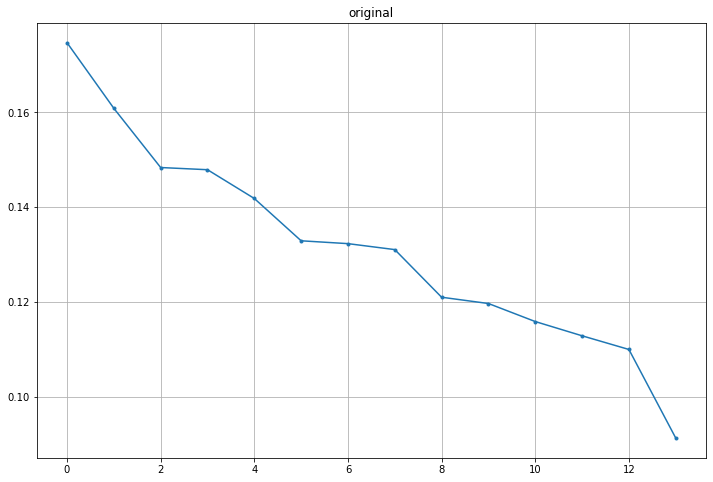

In [6]:
# N.B. set n_jobs > 1 to run in parallel (if you've got the cores)
ppp = make_preprocess_pipeline(pipeline)
res = datasets_GridSearchCV(ppp, filenames, loader, loader_args=loader_args,
                 cv=None, n_jobs=5, 
                 job_per_file=True, 
                 cv_clsfr_only=True)

scores = [ np.mean(s) for s in res['scores_cv']]
print("{} datasets scores = {} (+/-{}) [{}-{}]".format(len(scores),np.nanmedian(scores),np.nanstd(scores),np.nanmin(scores),np.nanmax(scores)))
plt.plot(np.sort(scores)[::-1],'.-');plt.title('original');plt.grid()

## extract the model and performance info from the trained info

In [7]:
# extract the models from the classifiers
clsfrs = [c.stages[-1][1] for c in res['clsfr']]
scores = [ np.mean(s) for s in res['scores_cv']]
labels = [ l for l in res['filename']]

In [8]:
# get conistent dataset in terms of #ch etc
ds   = [ c.W_.shape[-1] for c in clsfrs ]
taus = [ c.R_.shape[-1] for c in clsfrs ]
d = np.min(ds)
tau = np.min(taus)
print(ds)
print(taus)
print(scores)
keep = [ di>=d and taui>= tau for di,taui in zip(ds,taus)]
print('keeping {}/{} models'.format(sum(keep),len(keep)))

[32, 32, 32, 35, 32, 35, 35, 35, 35, 35, 35, 32, 35, 35, 35, 35, 32, 35, 35, 35, 35, 35]
[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
[0.18870414361260823, 0.15056826556206865, 0.15250734203938876, 0.132185702575191, 0.20838590281065042, 0.12749882691658823, 0.12749882691658823, 0.13163329596894363, 0.11460065003680023, 0.1014425391211906, 0.22655534913924394, 0.12229033824568375, 0.1412787737167074, 0.11916888339844509, 0.13270453838965535, 0.14189913328827714, 0.07638535793702189, 0.10986262824618498, 0.12464970243758627, 0.10131627628552098, 0.09356139985959787, 0.10700419130676472]
keeping 22/22 models


In [9]:

clsfrs = [c for c,k in zip(clsfrs,keep) if k]
scores = [c for c,k in zip(scores,keep) if k]
labels = [l for l,k in zip(labels,keep) if k]

In [10]:
# extract the models
W_Mkd = np.stack([c.W_[0,...,:d] if c.W_.ndim>2 else c.W_[...,:d] for c in clsfrs],0)
A_Mkd = np.stack([c.A_[0,...,:d] if c.A_.ndim>2 else c.A_[...,:d] for c in clsfrs],0)

In [11]:
# deal with small differences in the lenght of the IRF
taus = [ c.R_.shape[-1] for c in clsfrs ]
tau = np.min(taus)
R_Mket = np.stack([c.R_[0,...,:tau] if c.R_.ndim>3 else c.R_[...,:tau] for c in clsfrs],0)
I_Mket = np.stack([c.I_[0,...,:tau] if c.I_.ndim>3 else c.I_[...,:tau] for c in clsfrs],0)
times = np.arange(tau)/fs_out

In [12]:
# normalize the sign
# get a prototype -- just take the 1st..
muA_kd = A_Mkd[0:1,...] #np.mean(A_Mkd,0,keepdims=False)
muR_ket = np.mean(R_Mket,0,keepdims=False)

sgn_Mk = np.sign(np.sum(R_Mket[...,:,:] * muR_ket[...,:,:],axis=(-2,-1)))

print(sgn_Mk.T)

#print(sgn_Mk.reshape(sgn_Mk.shape+(1,)*(A_Mkd.ndim-1)).shape)
#print(sgn_Mk.reshape(sgn_Mk.shape+(1,)*(R_Mket.ndim-1)).shape)
#print()

A_Mkd = A_Mkd * sgn_Mk.reshape(sgn_Mk.shape+(1,)*(A_Mkd.ndim-sgn_Mk.ndim))
W_Mkd = W_Mkd * sgn_Mk.reshape(sgn_Mk.shape+(1,)*(W_Mkd.ndim-sgn_Mk.ndim))
R_Mket = R_Mket * sgn_Mk.reshape(sgn_Mk.shape+(1,)*(R_Mket.ndim-sgn_Mk.ndim))
I_Mket = I_Mket * sgn_Mk.reshape(sgn_Mk.shape+(1,)*(R_Mket.ndim-sgn_Mk.ndim))

# compute the average
muA_kd = np.mean(A_Mkd,0,keepdims=False)
muW_kd = np.mean(W_Mkd,0,keepdims=False)
muR_ket = np.mean(R_Mket,0,keepdims=False)
muI_ket = np.mean(I_Mket,0,keepdims=False)

for i,(f,s) in enumerate(zip(labels,scores)):
    print("{:2d}) {:60s} = {:3.2f}".format(i,os.path.basename(f),s))
print("----")
print("{}) {:60s} = {:3.2f}".format('  ','   ave    ',np.mean(scores)))

[[-1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.
  -1.  1. -1. -1.]]
 0) mindaffectBCI_audio_visual_threshold_audio_only_slow_211117_1716.txt = 0.19
 1) mindaffectBCI_audio_visual_threshold_audio_only_slow_211201_1435.txt = 0.15
 2) mindaffectBCI_audio_visual_threshold_audio_only_slow_211117_1429.txt = 0.15
 3) mindaffectBCI_audio_visual_threshold_audio_only_slow_211125_1639.txt = 0.13
 4) mindaffectBCI_audio_visual_threshold_audio_only_slow_211110_1150.txt = 0.21
 5) mindaffectBCI_audio_visual_threshold_audio_only_slow_211125_1227.txt = 0.13
 6) mindaffectBCI_audio_visual_threshold_audio_only_slow_211125_1227.txt = 0.13
 7) mindaffectBCI_audio_visual_threshold_audio_only_slow_211201_1034.txt = 0.13
 8) mindaffectBCI_audio_visual_threshold_audio_only_slow_211201_1054.txt = 0.11
 9) mindaffectBCI_audio_visual_threshold_audio_only_slow_211125_1514.txt = 0.10
10) mindaffectBCI_audio_visual_threshold_audio_only_slow_211118_1102.txt = 0.23
11) mindaffectBCI_audio_vi

## Plot the temporal response models over sessions

(1, 1, 31)


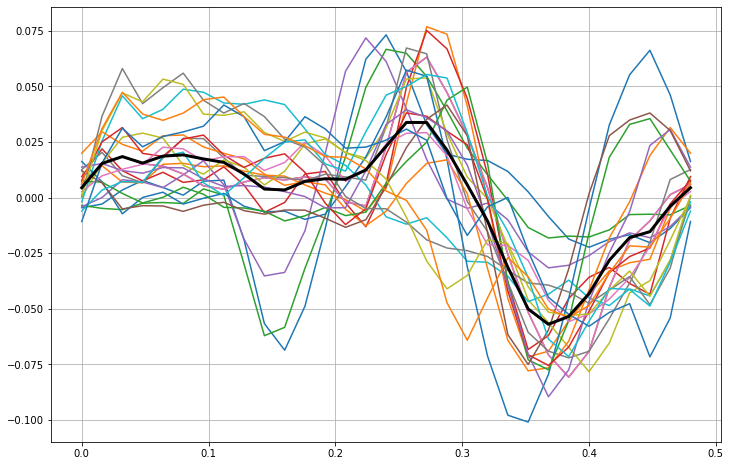

In [13]:
def plot_temporal_response(R_Mket,times):
    nrow=R_Mket.shape[-2]
    ncol=R_Mket.shape[-3]
    muR_ket = np.mean(R_Mket,0)
    for k in range(R_Mket.shape[-3]):
        for e in range(R_Mket.shape[-2]):
            #plt.title(evtlabs[0])
            plt.subplot(nrow,ncol,ncol*k+1+e)
            plt.plot(times,R_Mket[:,k,e,:].T)
            plt.plot(times,muR_ket[k,e,:].T,'k-',linewidth=3)
            plt.grid(True)
        #plt.title(evtlabs[1])
print(muR_ket.shape)
plot_temporal_response(R_Mket,times)
#plt.legend(["{} ({:3.2f})".format(f[-20:],m) for f,m in zip(labels,scores)] )
plt.show()

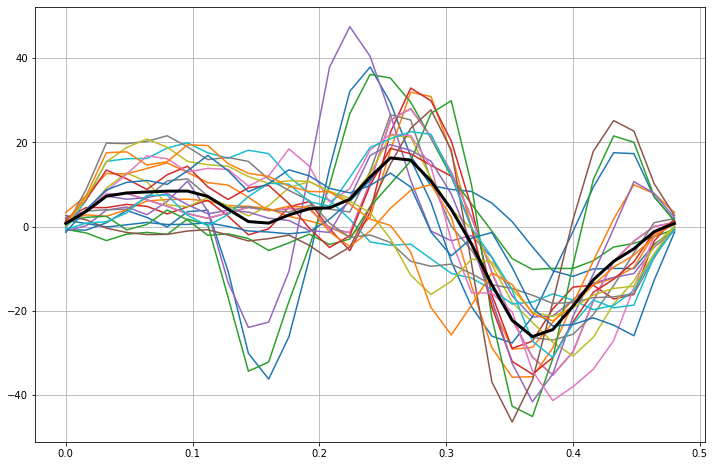

In [14]:
plot_temporal_response(I_Mket,times)
#plt.legend(["{} ({:3.2f})".format(f[-20:],m) for f,m in zip(labels,scores)] )
plt.show()

## plot the fitted spatial filters over sessions

['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2']
trying to get pos from cap file!
trying to get pos from cap file!


<Figure size 864x576 with 0 Axes>

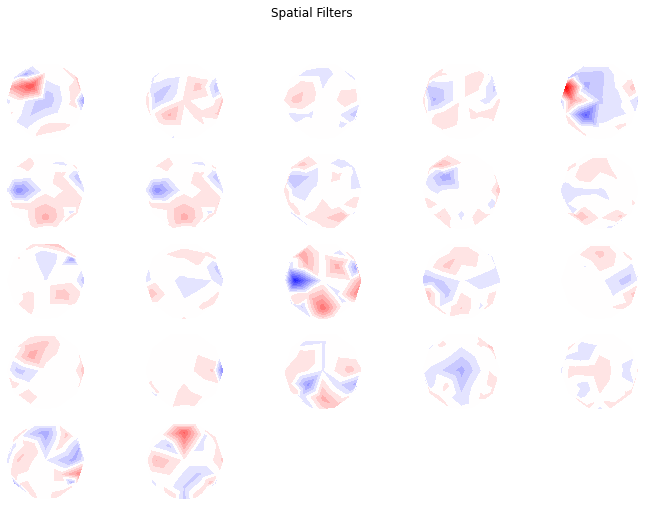

In [15]:
plt.figure()
from mindaffectBCI.decoder.updateSummaryStatistics import get_ch_pos, topoplots
ch_names = res['clsfr'][0].stages[0][1].info['ch_names']
ch_names = [ c if not c.endswith('.bad') else c[:-len('.bad')] for c in ch_names] # remove .bad postfix
print(ch_names)
ch_pos, iseeg = get_ch_pos(ch_names)
if sum(iseeg)>len(iseeg)*.7: # plot as set of topos
    topoplots(W_Mkd,ch_names)
    
else:
    plt.plot(W_Mkd[:,0,:].T)
    plt.plot(muW_kd[0,:].T,'k-',linewidth=3)
    plt.grid(True)
plt.suptitle('Spatial Filters')
plt.show()

## plot the fitted spatial patterns over sessions

['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2']
trying to get pos from cap file!
trying to get pos from cap file!


<Figure size 864x576 with 0 Axes>

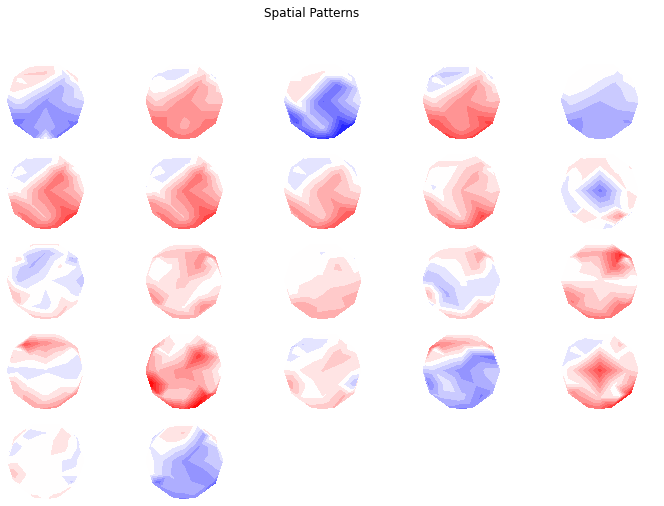

In [16]:
# plot the spatial patterns
plt.figure()
from mindaffectBCI.decoder.updateSummaryStatistics import get_ch_pos, topoplots
ch_names = res['clsfr'][0].stages[0][1].info['ch_names']
ch_names = [ c if not c.endswith('.bad') else c[:-len('.bad')] for c in ch_names]
print(ch_names)
ch_pos, iseeg = get_ch_pos(ch_names)
if sum(iseeg)>len(iseeg)*.7: # plot as set of topos
    topoplots(A_Mkd,ch_names)
else:
    plt.plot(A_Mkd[:,0,:].T)
    plt.plot(muA_kd[0,:].T,'k-',linewidth=3)
    plt.grid(True)
plt.suptitle('Spatial Patterns')
plt.show()

# generate a model basis from the set of temporal solutions

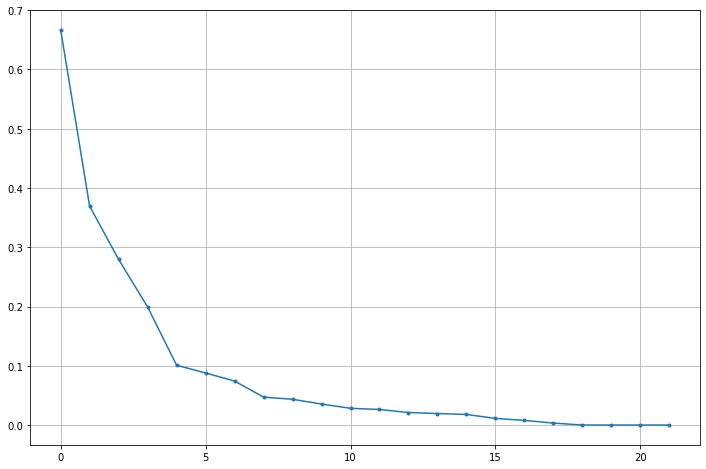

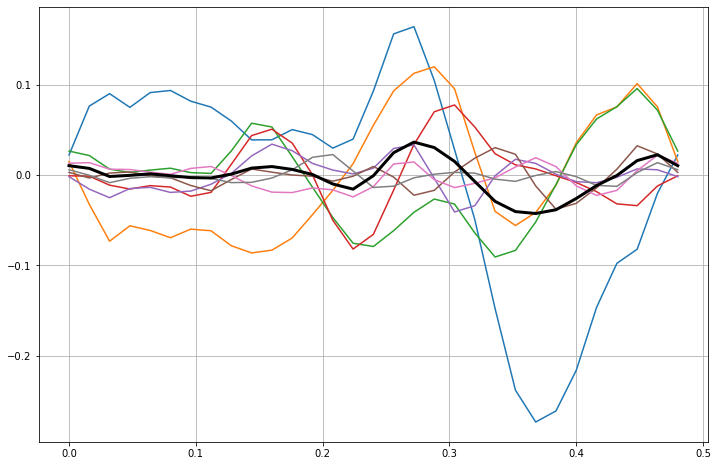

In [17]:
R_Mk_et = R_Mket.reshape((R_Mket.shape[0]*R_Mket.shape[1],-1))
U_Mk_i,S_i,V_i_et = np.linalg.svd(R_Mk_et,full_matrices=False)
plt.plot(S_i,'.-');plt.grid();plt.show()
temporal_basis_iet = V_i_et.reshape((V_i_et.shape[0],R_Mket.shape[2],R_Mket.shape[3]))
plot_temporal_response((temporal_basis_iet * S_i[:,np.newaxis,np.newaxis])[:8,np.newaxis,...],times)

In [22]:
import json
tmp_iet = temporal_basis_iet #* S_i[:,np.newaxis,np.newaxis] # scaled version?
for nc in (1,2,3,5,10):
    basis_file = 'am_temporal_basis_{}hz_{}comp.json'.format(fs_out,nc)
    print("Saving to: {}".format(basis_file))
    with open(os.path.join('../../resources/',basis_file),'w') as f:
        json.dump(tmp_iet[:nc,:,:].tolist(),f)

Saving to: am_temporal_basis_62.5hz_1comp.json
Saving to: am_temporal_basis_62.5hz_2comp.json
Saving to: am_temporal_basis_62.5hz_3comp.json
Saving to: am_temporal_basis_62.5hz_5comp.json
Saving to: am_temporal_basis_62.5hz_10comp.json


## try this sub-basis to fit the data

In [19]:
pipeline[-1][1]['temporal_basis']='am_temporal_basis_62.5hz.json'
ppp = make_preprocess_pipeline(pipeline)
print(ppp)
res = datasets_GridSearchCV(ppp, filenames, loader, loader_args=loader_args,
                 cv=None, n_jobs=5,
                 job_per_file=True,
                 cv_clsfr_only=True)


PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder()),
                           ('badchannelremover',
                            BadChannelRemover(mode='zero')),
                           ('noisesubspacedecorrelator',
                            NoiseSubspaceDecorrelator(ch_names=['Fp1', 'Fp2',
                                                                'F9', 'F10'])),
                           ('targetencoder', TargetEncoder(evtlabs='re')),
                           ('clsfr',
                            LevelsCCA(tau_ms=500,
                                      temporal_basis='am_temporal_basis_62.5hz.json'))])
Running with 5 parallel tasks, one-per-filename
Submitting {} jobs:......................22 jobs submitted in    0s. Waiting results.

4% 1 / 22 collected in 29.6s  est 652.0s total 622.3s remaining
9% 2 / 22 collected in 36.8s  est 405.0s total 368.2s remaining
13% 3 / 22 collected in 39.8s  est 292.1s total 252.2s remaining
22% 5 / 22 collected in 51.1s  es

22 datasets scores = 0.12569619530739498 (+/-0.0346750198645982) [0.07511588829188118-0.22500509120232157]


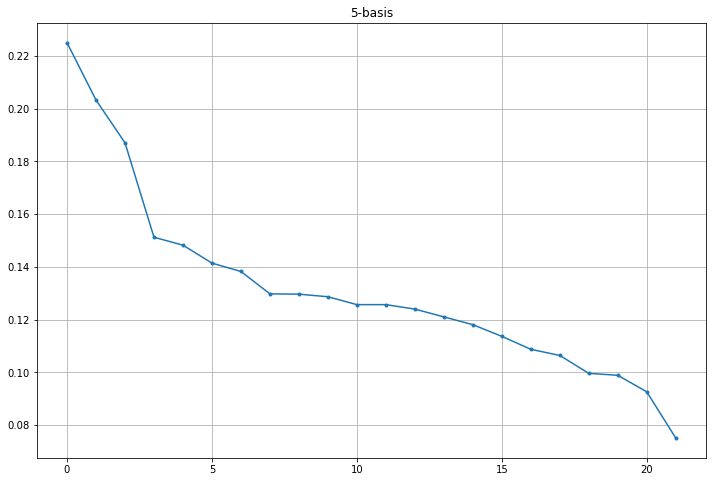

In [20]:
scores = [ np.mean(s) for s in res['scores_cv']]
print("{} datasets scores = {} (+/-{}) [{}-{}]".format(len(scores),np.nanmedian(scores),np.nanstd(scores),np.nanmin(scores),np.nanmax(scores)))
plt.plot(np.sort(scores)[::-1],'.-');plt.title('5-basis');plt.grid()

## run a cross-session parameter tuning run

In [10]:
# Audio metric analysis, levels analysis
loader_fs = 62.5
loader_filterband=((.5,45,'bandpass'),)
artifact_ch=['Fp1', 'Fp2', 'F9', 'F10']
tau_ms=650
offset_ms=200
filterband=[(2,10,'bandpass')]
fs_out=None
rank=1 
evtlabs=('re')
temporal_basis='wf2,10'
levels_basis=None


loader_args = dict(filterband=loader_filterband, fs_out = loader_fs)

pipeline=[
    'MetaInfoAdder',
    ['BadChannelRemover',{'mode':'zero'}],
    ['NoiseSubspaceDecorrelator', {'ch_names':artifact_ch}],
    ['ButterFilterAndResampler:filt',{'filterband':filterband, 'fs_out':fs_out}],
    ["TimeShifter", {"timeshift_ms":offset_ms}],
    #['TargetEncoder',{'evtlabs':evtlabs}],
    ['mindaffectBCI.decoder.levelCCA.LevelsCCA:clsfr', {'tau_ms': tau_ms, 'evtlabs': evtlabs, "rank": rank, "temporal_basis": temporal_basis, "perlevelweight": True, "levels_basis": levels_basis}],
]

In [18]:
# try diff analysis windows
tuned_parameters = [{'timeshifter__timeshift_ms':[0], 'clsfr__tau_ms':[650,750,850]},
                    {'timeshifter__timeshift_ms':[100], 'clsfr__tau_ms':[550,650,750]},
                    {'timeshifter__timeshift_ms':[200], 'clsfr__tau_ms':[450,550,650]}
                   ]
ppp = make_preprocess_pipeline(pipeline)
print(ppp) 
res = datasets_GridSearchCV(ppp, filenames, loader, loader_args=loader_args,
                 cv=5, n_jobs=16, tuned_parameters=tuned_parameters,
                 job_per_file=True,
                 cv_clsfr_only=True)

PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder()),
                           ('badchannelremover',
                            BadChannelRemover(mode='zero')),
                           ('noisesubspacedecorrelator',
                            NoiseSubspaceDecorrelator(ch_names=['Fp1', 'Fp2',
                                                                'F9', 'F10'])),
                           ('filt',
                            ButterFilterAndResampler(filterband=[(2, 10,
                                                                  'bandpass')])),
                           ('timeshifter', TimeShifter(timeshift_ms=200)),
                           ('clsfr',
                            LevelsCCA(evtlabs='re', tau_ms=650,
                                      temporal_basis='wf2,10'))])
Running with 16 parallel tasks, one-per-filename
Submitting {} jobs:..Loading /home/shared/drive/Audiometric Threshold/audio_visual_threshold_audio_only_both_ears_5Hz_VID/s0/22011

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1715, in load_and_GridSearchCV
    future = set_params_cv(clsfr, X, Y, cv, fit_config, fit_params=fit_params, extra_config=extra_config, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1653, in set_params_cv
    scores = cv_fit(clsfr, X.copy(), Y.copy(), cv=cv, fit_params=fit_params, cv_clsfr_only=cv_clsfr_only)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1226, in cv_fit
    res = clsfr.stages[-1][1].cv_fit(Xpp, Ypp, cv=cv, fit_params=fit_params, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/model_fitting.py", line 611, in cv_fit
    self.fit(X_TSd[train_idx

18% 2 / 11 collected in 304.2s  est 1673.3s total 1369.0s remaining
27% 3 / 11 collected in 311.4s  est 1141.6s total 830.3s remaining
36% 4 / 11 collected in 328.4s  est 903.1s total 574.7s remaining
63% 7 / 11 collected in 331.5s  est 520.9s total 189.4s remaining
90% 10 / 11 collected in 345.5s  est 380.0s total 34.5s remaining


{'clsfr__tau_ms': 650, 'timeshifter__timeshift_ms': 0}  = 0.220 (+/-0.044) [0.155-0.297]
{'clsfr__tau_ms': 750, 'timeshifter__timeshift_ms': 0}  = 0.230 (+/-0.046) [0.158-0.309]
{'clsfr__tau_ms': 850, 'timeshifter__timeshift_ms': 0}  = 0.234 (+/-0.047) [0.160-0.316]
{'clsfr__tau_ms': 550, 'timeshifter__timeshift_ms': 100}  = 0.218 (+/-0.043) [0.155-0.289]
{'clsfr__tau_ms': 650, 'timeshifter__timeshift_ms': 100}  = 0.230 (+/-0.045) [0.158-0.308]
{'clsfr__tau_ms': 750, 'timeshifter__timeshift_ms': 100}  = 0.234 (+/-0.045) [0.159-0.311]
{'clsfr__tau_ms': 450, 'timeshifter__timeshift_ms': 200}  = 0.212 (+/-0.042) [0.151-0.278]
{'clsfr__tau_ms': 550, 'timeshifter__timeshift_ms': 200}  = 0.228 (+/-0.045) [0.158-0.302]
{'clsfr__tau_ms': 650, 'timeshifter__timeshift_ms': 200}  = 0.233 (+/-0.046) [0.158-0.309]


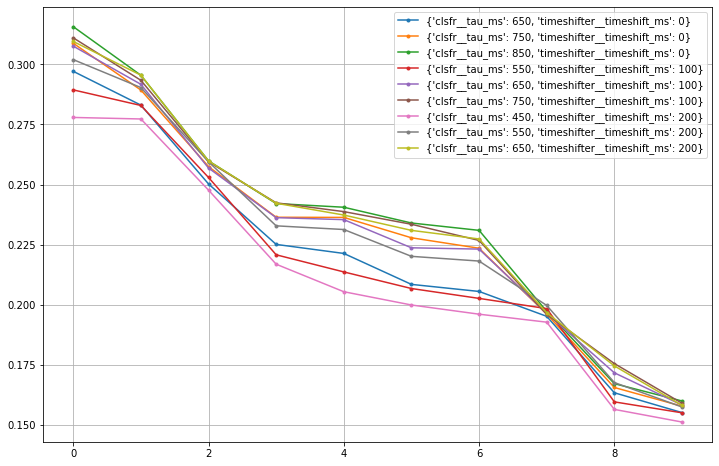

In [19]:
configresults, configs, configrows = get_results_per_config(res)
summary=[]
for config,configres in configresults.items():
    scores = [ np.mean(s) for s in configres['scores_cv'] ]
    summary.append((np.nanmean(scores),"{} = {:5.3f} (+/-{:5.3f}) [{:5.3f}-{:5.3f}]".format(config, np.nanmean(scores),np.nanstd(scores),np.nanmin(scores),np.nanmax(scores))))
    plt.plot(np.sort(scores)[::-1],'.-',label=str(config))
summary.sort(reverse=True,key=lambda a:a[0])
for _,s in summary:
    print(s)
plt.legend()
plt.grid()

In [26]:
# try diff spectral filters
tuned_parameters = {'filt__filterband':[(2,10,'bandpass'),(2,15,'bandpass'),(2,20,'bandpass'),
                                       (1,10,'bandpass'),(1,15,'bandpass'),(1,20,'bandpass'),
                                       (3,10,'bandpass'),(3,15,'bandpass'),(3,20,'bandpass'),
                                       (4,10,'bandpass'),(4,15,'bandpass'),(4,20,'bandpass')]}
ppp = make_preprocess_pipeline(pipeline)
print(ppp) 
res = datasets_GridSearchCV(ppp, filenames, loader, loader_args=loader_args,
                 cv=4, n_jobs=16, tuned_parameters=tuned_parameters,
                 job_per_file=True,
                 cv_clsfr_only=True)

PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder()),
                           ('badchannelremover',
                            BadChannelRemover(mode='zero')),
                           ('noisesubspacedecorrelator',
                            NoiseSubspaceDecorrelator(ch_names=['Fp1', 'Fp2',
                                                                'F9', 'F10'])),
                           ('filt',
                            ButterFilterAndResampler(filterband=[(2, 10,
                                                                  'bandpass')])),
                           ('timeshifter', TimeShifter(timeshift_ms=200)),
                           ('clsfr',
                            LevelsCCA(evtlabs='re', tau_ms=650,
                                      temporal_basis='wf2,10'))])
Running with 16 parallel tasks, one-per-filename
Submitting {} jobs:...........11 jobs submitted in    1s. Waiting results.

Loading /home/shared/drive/Audiometric Threshold/audio

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1715, in load_and_GridSearchCV
    future = set_params_cv(clsfr, X, Y, cv, fit_config, fit_params=fit_params, extra_config=extra_config, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1653, in set_params_cv
    scores = cv_fit(clsfr, X.copy(), Y.copy(), cv=cv, fit_params=fit_params, cv_clsfr_only=cv_clsfr_only)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1226, in cv_fit
    res = clsfr.stages[-1][1].cv_fit(Xpp, Ypp, cv=cv, fit_params=fit_params, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/model_fitting.py", line 611, in cv_fit
    self.fit(X_TSd[train_idx

18% 2 / 11 collected in 410.5s  est 2257.8s total 1847.3s remaining
27% 3 / 11 collected in 426.0s  est 1562.0s total 1136.0s remaining
63% 7 / 11 collected in 429.6s  est 675.0s total 245.5s remaining
72% 8 / 11 collected in 434.2s  est 597.0s total 162.8s remaining
81% 9 / 11 collected in 442.1s  est 540.4s total 98.2s remaining
100% 11 / 11 collected in 450.7s  est 450.7s total  0.0s remaining


{'filt__filterband': (4, 10, 'bandpass')} = 0.260 (+/-0.048) [0.179-0.340]
{'filt__filterband': (3, 10, 'bandpass')} = 0.252 (+/-0.048) [0.172-0.334]
{'filt__filterband': (2, 10, 'bandpass')} = 0.233 (+/-0.046) [0.158-0.309]
{'filt__filterband': (4, 15, 'bandpass')} = 0.223 (+/-0.046) [0.149-0.314]
{'filt__filterband': (3, 15, 'bandpass')} = 0.221 (+/-0.047) [0.143-0.312]
{'filt__filterband': (2, 15, 'bandpass')} = 0.210 (+/-0.044) [0.137-0.288]
{'filt__filterband': (4, 20, 'bandpass')} = 0.206 (+/-0.045) [0.135-0.297]
{'filt__filterband': (3, 20, 'bandpass')} = 0.205 (+/-0.047) [0.128-0.296]
{'filt__filterband': (1, 10, 'bandpass')} = 0.199 (+/-0.040) [0.135-0.268]
{'filt__filterband': (2, 20, 'bandpass')} = 0.197 (+/-0.042) [0.124-0.276]
{'filt__filterband': (1, 15, 'bandpass')} = 0.183 (+/-0.039) [0.123-0.255]
{'filt__filterband': (1, 20, 'bandpass')} = 0.175 (+/-0.037) [0.115-0.245]


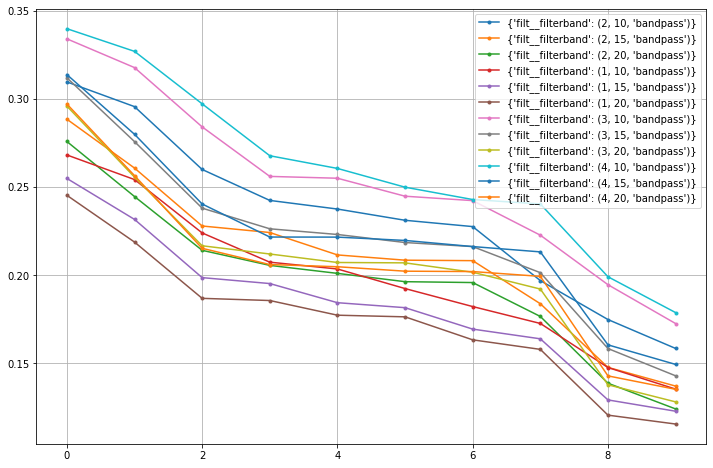

In [27]:
configresults, configs, configrows = get_results_per_config(res)
summary=[]
for config,configres in configresults.items():
    scores = [ np.mean(s) for s in configres['scores_cv'] ]
    summary.append((np.nanmean(scores),"{} = {:5.3f} (+/-{:5.3f}) [{:5.3f}-{:5.3f}]".format(config, np.nanmean(scores),np.nanstd(scores),np.nanmin(scores),np.nanmax(scores))))
    plt.plot(np.sort(scores)[::-1],'.-',label=str(config))
summary.sort(reverse=True,key=lambda a:a[0])
for _,s in summary:
    print(s)
plt.legend()
plt.grid()

In [28]:
# try diff temporal basis
tuned_parameters = {'clsfr__temporal_basis':['wf2,8','wf2,10','wf2,15','rbf2','rbf1']}
ppp = make_preprocess_pipeline(pipeline)
print(ppp) 
res = datasets_GridSearchCV(ppp, filenames, loader, loader_args=loader_args,
                 cv=4, n_jobs=16, tuned_parameters=tuned_parameters,
                 job_per_file=True,
                 cv_clsfr_only=True)

PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder()),
                           ('badchannelremover',
                            BadChannelRemover(mode='zero')),
                           ('noisesubspacedecorrelator',
                            NoiseSubspaceDecorrelator(ch_names=['Fp1', 'Fp2',
                                                                'F9', 'F10'])),
                           ('filt',
                            ButterFilterAndResampler(filterband=[(2, 10,
                                                                  'bandpass')])),
                           ('timeshifter', TimeShifter(timeshift_ms=200)),
                           ('clsfr',
                            LevelsCCA(evtlabs='re', tau_ms=650,
                                      temporal_basis='wf2,10'))])
Running with 16 parallel tasks, one-per-filename
Submitting {} jobs:...........11 jobs submitted in    1s. Waiting results.

Loading /home/shared/drive/Audiometric Threshold/audio

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1715, in load_and_GridSearchCV
    future = set_params_cv(clsfr, X, Y, cv, fit_config, fit_params=fit_params, extra_config=extra_config, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1653, in set_params_cv
    scores = cv_fit(clsfr, X.copy(), Y.copy(), cv=cv, fit_params=fit_params, cv_clsfr_only=cv_clsfr_only)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1226, in cv_fit
    res = clsfr.stages[-1][1].cv_fit(Xpp, Ypp, cv=cv, fit_params=fit_params, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/model_fitting.py", line 611, in cv_fit
    self.fit(X_TSd[train_idx

18% 2 / 11 collected in 251.4s  est 1382.9s total 1131.5s remaining
27% 3 / 11 collected in 257.4s  est 943.7s total 686.3s remaining
54% 6 / 11 collected in 262.6s  est 481.4s total 218.8s remaining
72% 8 / 11 collected in 268.8s  est 369.6s total 100.8s remaining
81% 9 / 11 collected in 274.8s  est 335.9s total 61.1s remaining
100% 11 / 11 collected in 282.3s  est 282.3s total  0.0s remaining


{'clsfr__temporal_basis': 'wf2,8'}  = 0.233 (+/-0.046) [0.158-0.309]
{'clsfr__temporal_basis': 'wf2,10'}  = 0.233 (+/-0.046) [0.158-0.309]
{'clsfr__temporal_basis': 'wf2,15'}  = 0.233 (+/-0.046) [0.158-0.310]
{'clsfr__temporal_basis': 'rbf2'}  = 0.235 (+/-0.045) [0.160-0.310]
{'clsfr__temporal_basis': 'rbf1'}  = 0.235 (+/-0.045) [0.160-0.310]


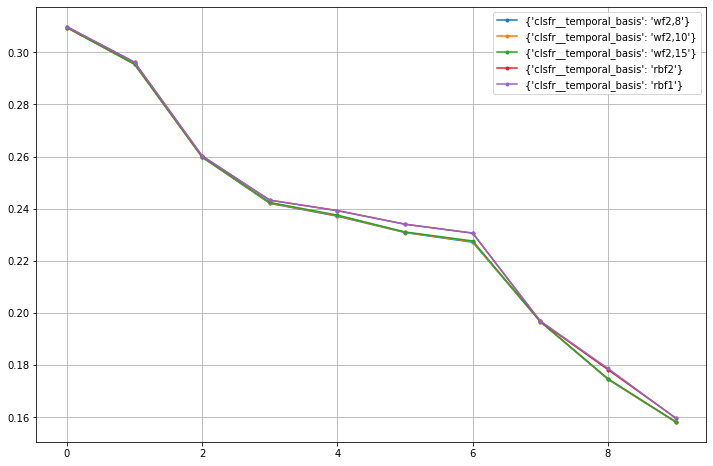

In [17]:
configresults, configs, configrows = get_results_per_config(res)
summary=[]
for config,configres in configresults.items():
    scores = [ np.mean(s) for s in configres['scores_cv'] ]
    summary.append((np.nanmean(scores),"{} = {:5.3f} (+/-{:5.3f}) [{:5.3f}-{:5.3f}]".format(config, np.nanmean(scores),np.nanstd(scores),np.nanmin(scores),np.nanmax(scores))))
    plt.plot(np.sort(scores)[::-1],'.-',label=str(config))
summary.sort(reverse=True,key=lambda a:a[0])
for _,s in summary:
    print(s)
plt.legend()
plt.grid()

In [29]:
# try diff levels basis
tuned_parameters = {'clsfr__levels_basis':['hinge','step',None,'rbf1']}
ppp = make_preprocess_pipeline(pipeline)
print(ppp) 
res = datasets_GridSearchCV(ppp, filenames, loader, loader_args=loader_args,
                 cv=4, n_jobs=16, tuned_parameters=tuned_parameters,
                 job_per_file=True,
                 cv_clsfr_only=True)

PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder()),
                           ('badchannelremover',
                            BadChannelRemover(mode='zero')),
                           ('noisesubspacedecorrelator',
                            NoiseSubspaceDecorrelator(ch_names=['Fp1', 'Fp2',
                                                                'F9', 'F10'])),
                           ('filt',
                            ButterFilterAndResampler(filterband=[(2, 10,
                                                                  'bandpass')])),
                           ('timeshifter', TimeShifter(timeshift_ms=200)),
                           ('clsfr',
                            LevelsCCA(evtlabs='re', tau_ms=650,
                                      temporal_basis='wf2,10'))])
Running with 16 parallel tasks, one-per-filename
Submitting {} jobs:..Loading /home/shared/drive/Audiometric Threshold/audio_visual_threshold_audio_only_both_ears_5Hz_VID/s0/22011

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1715, in load_and_GridSearchCV
    future = set_params_cv(clsfr, X, Y, cv, fit_config, fit_params=fit_params, extra_config=extra_config, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1653, in set_params_cv
    scores = cv_fit(clsfr, X.copy(), Y.copy(), cv=cv, fit_params=fit_params, cv_clsfr_only=cv_clsfr_only)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/analyse_datasets.py", line 1226, in cv_fit
    res = clsfr.stages[-1][1].cv_fit(Xpp, Ypp, cv=cv, fit_params=fit_params, **kwargs)
  File "/home/jupyter-jason/private/mindaffectBCI/decoder/model_fitting.py", line 611, in cv_fit
    self.fit(X_TSd[train_idx

18% 2 / 11 collected in 150.9s  est 830.2s total 679.2s remaining
27% 3 / 11 collected in 156.0s  est 571.9s total 415.9s remaining
36% 4 / 11 collected in 159.0s  est 437.3s total 278.3s remaining
54% 6 / 11 collected in 164.4s  est 301.4s total 137.0s remaining
72% 8 / 11 collected in 173.5s  est 238.6s total 65.1s remaining
90% 10 / 11 collected in 177.1s  est 194.8s total 17.7s remaining


{'clsfr__levels_basis': None} = 0.233 (+/-0.046) [0.158-0.309]
{'clsfr__levels_basis': 'step'} = 0.228 (+/-0.048) [0.151-0.308]
{'clsfr__levels_basis': 'rbf1'} = 0.226 (+/-0.048) [0.153-0.305]
{'clsfr__levels_basis': 'hinge'} = 0.223 (+/-0.048) [0.146-0.305]


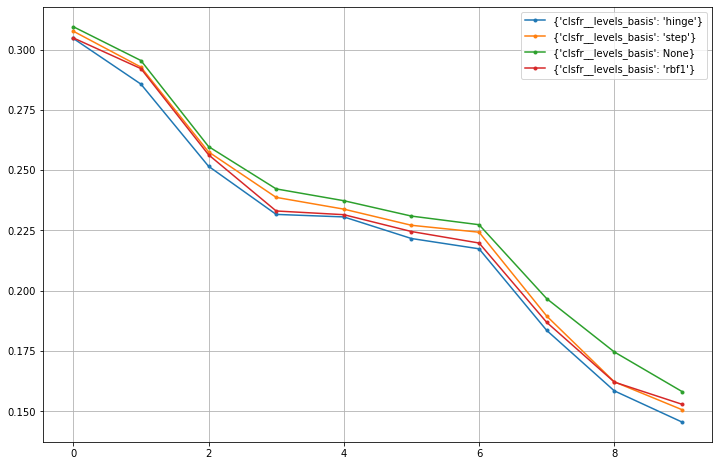

In [31]:
configresults, configs, configrows = get_results_per_config(res)
summary=[]
for config,configres in configresults.items():
    scores = [ np.mean(s) for s in configres['scores_cv'] ]
    summary.append((np.nanmean(scores),"{} = {:5.3f} (+/-{:5.3f}) [{:5.3f}-{:5.3f}]".format(config, np.nanmean(scores),np.nanstd(scores),np.nanmin(scores),np.nanmax(scores))))
    plt.plot(np.sort(scores)[::-1],'.-',label=str(config))
summary.sort(reverse=True,key=lambda a:a[0])
for _,s in summary:
    print(s)
plt.legend()
plt.grid()

In [ ]:
# try diff weight basis
tuned_parameters = {'clsfr__levels_basis':[None,'step','hinge']
                    }
ppp = make_preprocess_pipeline(pipeline)
print(ppp) 
res = datasets_GridSearchCV(ppp, filenames, loader, loader_args=loader_args,
                 cv=4, n_jobs=16, tuned_parameters=tuned_parameters,
                 job_per_file=True,
                 cv_clsfr_only=True)

{'clsfr__levels_basis': None}  = 0.117 (+/-0.077) [-0.033-0.224]
{'clsfr__levels_basis': 'step'}  = 0.131 (+/-0.066) [0.019-0.233]
{'clsfr__levels_basis': 'hinge'}  = 0.135 (+/-0.063) [0.030-0.236]


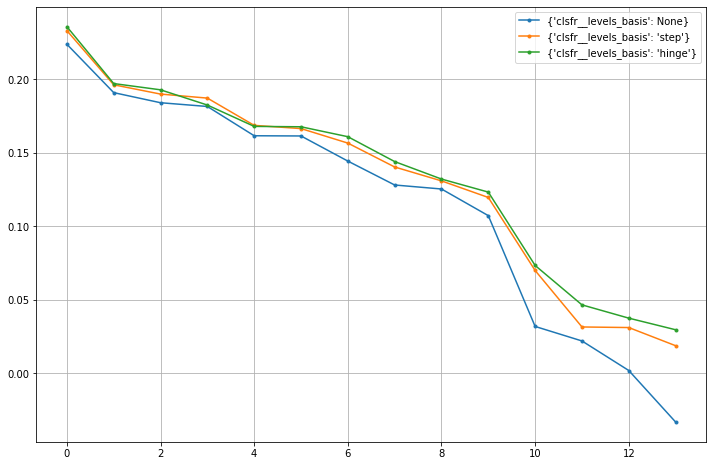

In [10]:
summary=[]
for config,configres in configresults.items():
    scores = [ np.mean(s) for s in configres['scores_cv'] ]
    summary.append((np.nanmean(scores),"{} = {:5.3f} (+/-{:5.3f}) [{:5.3f}-{:5.3f}]".format(config, np.nanmean(scores),np.nanstd(scores),np.nanmin(scores),np.nanmax(scores))))
    plt.plot(np.sort(scores)[::-1],'.-',label=str(config))
summary.sort(reverse=True,key=lambda a:a[0])
for _,s in summary:
    print(s)
plt.legend()
plt.grid()

## run a cross session model test

In [ ]:
import concurrent.futures
import mindaffectBCI.decoder.juypter_executor as juypter_executor
from mindaffectBCI.decoder.analyse_datasets import load_and_score_dataset
max_workers=8
executor = concurrent.futures.ProcessPoolExecutor(max_workers=max_workers)
print("Running with {} parallel tasks".format(max_workers))
parallel = True

clsfrs = [ m['clsfr'] for m in models]

futures=[]
for fi,filename in enumerate(fns):
    print("{}/{} ---- {} ----".format(fi,len(fns),os.path.basename(filename)))
    if parallel: 
        future = juypter_executor.submit(executor, load_and_score_dataset, load_dataset, filename, clsfrs, loader_args=loader_args, preprocess_args=preprocess_args, clsfr_args=clsfr_args)
    else:
        future = load_and_score_dataset(load_dataset,filename,clsfrs, loader_args=loader_args, preprocess_args=preprocess_args, clsfr_args=clsfr_args)
    futures.append(future)

ss = [ None for _ in fns ]
for future in concurrent.futures.as_completed(futures):
    scores, filename = future.result() if parallel else future
    ss[ fns.index(filename) ] = scores # insert in the right row
ss=np.array(ss)

## Plot the cross-session results

In [ ]:
plt.imshow(ss,aspect='auto')
plt.clim(0,1)
plt.title('Cross session performance')
plt.xlabel('Training dataset')
plt.ylabel('Testing dataset')
plt.colorbar()

In [228]:
J_ls = lambda s_y: C - 2 * C_y @ s_y + s_y.T @ C_yy @ s_y
# gradient
dJ_ls = lambda s_y: -2 * C_y + 2 * C_yy @ s_y
# opt-scale for given parameters
opt_scale = lambda s_y: (C_y @ s_y) / (s_y.T @ C_yy @ s_y)

In [229]:
nY = 4
C = np.random.standard_normal((1,))
C_y = np.random.standard_normal((nY,))
C_yy = np.random.standard_normal((100,nY)); C_yy = C_yy.T @ C_yy # pos-def

In [234]:
s_y = np.random.standard_normal(C_y.shape[0])


[array([-1.42571725]), array([-1.42590736]), array([-1.42604994]), array([-1.426145]), array([-1.42619252]), array([-1.42619252]), array([-1.426145]), array([-1.42604994]), array([-1.42590736]), array([-1.42571725])]
(10, 4)


Text(0.5, 1.0, 'Least Squares')

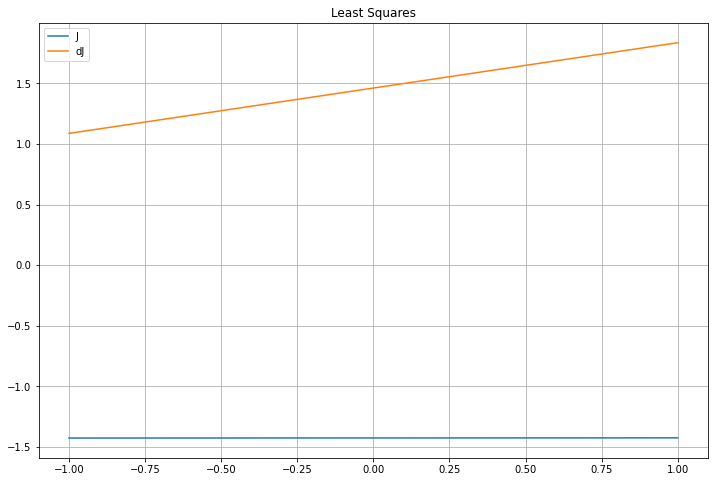

In [239]:
deltas = np.linspace(-1,1,10)
s = opt_scale(s_y)
print([ J_ls(s_y*(s*ds)) for ds in np.linspace(.5,1.5,10)])

Js = [ J_ls(np.concatenate(([s_y[0]+x],s_y[1:]))*s/3) for x in deltas ]
dJs = np.stack([ dJ_ls(np.concatenate(([s_y[0]+x],s_y[1:]))*s) for x in deltas ])
print(dJs.shape)
plt.plot(deltas,Js,label='J')
plt.plot(deltas,dJs[:,0],label='dJ')
plt.grid(True)
plt.legend()
plt.title("Least Squares")

In [247]:
# GD to optimise the parameters (cg faster)
s_y = np.random.standard_normal(C_y.shape[0])
step = 1e-4
s = opt_scale(s_y)
print(s)
loss = J_ls(s_y*s)
print("{}) J={} {}".format(0,loss, "+"))
for iter in range(100):
    oloss, os_y = loss, s_y
    s = opt_scale(s_y)
    #print(s)
    grad = dJ_ls(s_y*s)
    #print(grad)
    s_y = s_y - step * grad
    loss = J_ls(s_y*s)
    if loss>oloss: # back-track
        print("{}) J={} {}".format(iter,loss, "+" if loss<oloss else '-'))
        s_y = os_y
        loss = oloss
        step = step / 2
        continue
    else:
        step = step * 1.5
    print("{}) J={} {}".format(iter,loss, "+" if loss<oloss else '-'))
    if np.abs(loss-oloss)< 1e-3: 
        break
print(s_y)

-0.004209186940052861
0) J=[-1.43073969] +
0) J=[-1.43073765] -
1) J=[-1.43073867] -
2) J=[-1.43073918] -
3) J=[-1.43073944] -
4) J=[-1.43073956] -
5) J=[-1.43073963] -
6) J=[-1.43073966] -
7) J=[-1.43073968] -
8) J=[-1.43073968] -
9) J=[-1.43073969] -
10) J=[-1.43073969] -
11) J=[-1.43073969] -
12) J=[-1.43073969] -
13) J=[-1.43073969] -
14) J=[-1.43073969] -
15) J=[-1.43073969] -
16) J=[-1.43073969] -
17) J=[-1.43073969] -
18) J=[-1.43073969] -
19) J=[-1.43073969] -
20) J=[-1.43073969] -
21) J=[-1.43073969] -
22) J=[-1.43073969] -
23) J=[-1.43073969] -
24) J=[-1.43073969] -
25) J=[-1.43073969] -
26) J=[-1.43073969] -
27) J=[-1.43073969] -
28) J=[-1.43073969] -
29) J=[-1.43073969] -
30) J=[-1.43073969] -
31) J=[-1.43073969] -
32) J=[-1.43073969] -
33) J=[-1.43073969] -
34) J=[-1.43073969] -
[ 1.38032798 -0.65185028 -1.20226966  0.54380072]


In [161]:
s_exp = lambda e_y: np.exp(e_y)
ds_exp = lambda e_y: np.exp(e_y)

In [249]:
Jexp = lambda e_y,s=1: J_ls(s_exp(e_y)*s)
dJdexp = lambda e_y,s=1: ds_exp(e_y).T @ dJ_ls(s_exp(e_y)*s) * s

In [250]:
#dJdexp(e_y).shape
e_y.shape
#Jexp(e_y).shape
#dJ_ls(Jexp(e_y)).shape

(4,)

In [254]:
# GD to optimise the parameters (cg faster)
e_y = np.random.standard_normal(C_y.shape[0])
step = 1e-3
s = opt_scale(s_y)
print(s)
loss = J_ls(s_y*s)
print("{}) J={} {}".format(0,loss, "+"))
for iter in range(100):
    oloss = loss
    s = opt_scale(s_exp(e_y)) # opt-scale for this setting
    grad = dJdexp(e_y,s)
    #print(grad)
    e_y = e_y - step * grad
    loss = Jexp(e_y,s)
    if loss>oloss:
        e_y = e_y + step * grad
        loss = Jexp(e_y,s)
        step = step / 2
    else:
        step = step * 1.5
    print("{}) J={} {}".format(iter,loss, "+" if loss<oloss else '-'))
    if np.abs(loss-oloss)< 1e-3: break
print(s_exp(e_y)*s)

-0.004209186940052824
0) J=[-1.43073969] +
0) J=[-1.43802026] +
1) J=[-1.43802026] -
[0.00343726 0.00287523 0.00830074 0.00814122]


In [213]:
xs = np.linspace(-3,3,30)


Text(0.5, 1.0, 'Logistic')

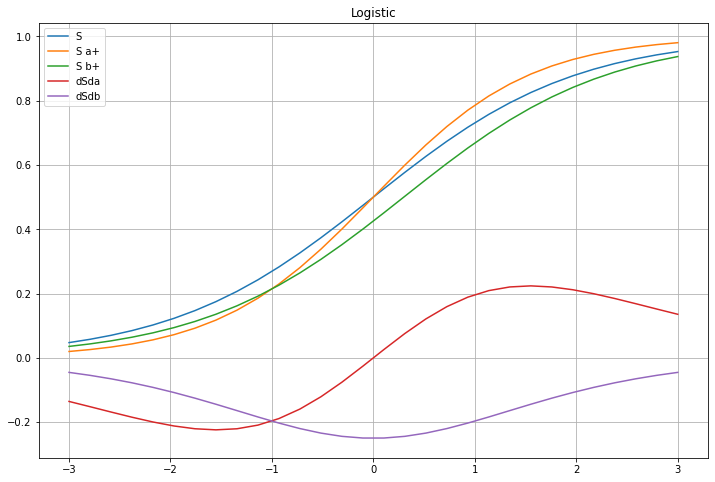

In [259]:
ab=[1,np.mean(xs)]
Ss = fs_y(xs,ab)
dss_ab_x = dfs_y(xs,ab)
plt.plot(xs,fs_y(xs,ab),label='S')
plt.plot(xs,fs_y(xs,[ab[0]+.3,ab[1]]),label='S a+')
plt.plot(xs,fs_y(xs,[ab[0],ab[1]+.3]),label='S b+')
plt.plot(xs,dss_ab_x[0,:],label='dSda')
plt.plot(xs,dss_ab_x[1,:],label='dSdb')
plt.legend()
plt.grid(True)
plt.title('Logistic')

In [261]:
xs = np.arange(C_y.shape[0])
Jab = lambda xs,ab,s=1: J_ls(fs_y(xs,ab)*s)
dJdab = lambda xs,ab,s=1: dfs_y(xs,ab) @ dJ_ls(fs_y(xs,ab)*s) * s

dJdab(xs,ab).shape

(2,)

Text(0.5, 1.0, 'Logistic')

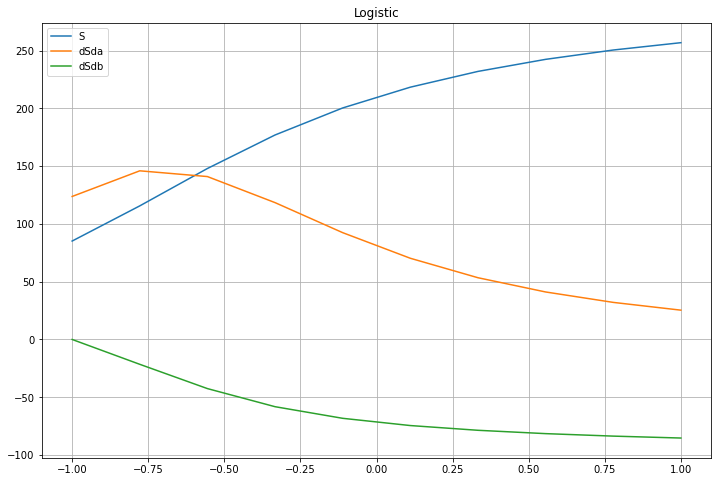

In [262]:
da = np.linspace(-1,1,10)
Js =[Jab(xs,[ab[0]+d,ab[1]]) for d in da]
dJsdab = np.stack([ dJdab(xs,[ab[0]+d,ab[1]]) for d in da ])
plt.plot(da,Js,label='S')
plt.plot(da,dJsdab[:,0],label='dSda')
plt.plot(da,dJsdab[:,1],label='dSdb')
plt.legend()
plt.grid(True)
plt.title('Logistic')

In [281]:
# GD to optimise the parameters (cg faster)
ab=[1,np.mean(xs)]
max_iter = 30 
tol = 1e-3
step = .001

s = opt_scale(fs_y(xs,ab))
loss = Jab(xs, ab, s)
print(loss)
for iter in range(max_iter):
    oloss, oab = loss, ab
    s = opt_scale(fs_y(xs,ab))
    grad = dJdab(xs, ab, s)
    #print(grad)
    ab = ab - step * grad
    s = opt_scale(fs_y(xs,ab))
    loss = Jab(xs, ab, s)
    if loss>oloss: # backtrack and reduce the step size
        print("{:3d}) [{}] dJ={:5.3f} {}  {:5.3f}".format(iter,ab,oloss-loss, "+" if loss<oloss else '-',step))
        ab = oab
        loss = oloss
        step = step / 2 # decrease the step size rapidly
        continue # restart this iteration with smaller step
    else: # increase the step size slowly
        step = min(step * 1.5,1)
    print("{:3d}) [{}] J={:5.3f} dJ={:5.3f} {}  {:5.3f}".format(iter,ab,float(loss),float(oloss-loss), "+" if loss<oloss else '-', step))
    if iter>3 and np.abs(loss-oloss)<tol: 
        break
print(ab)
print(fs_y(xs,ab)*s)


[-1.43925665]
  0) [[1.00000218 1.50000133]] J=-1.439 dJ=0.000 +  0.002
  1) [[1.00000546 1.50000333]] J=-1.439 dJ=0.000 +  0.002
  2) [[1.00001038 1.50000633]] J=-1.439 dJ=0.000 +  0.003
  3) [[1.00001775 1.50001083]] J=-1.439 dJ=0.000 +  0.005
  4) [[1.00002881 1.50001758]] J=-1.439 dJ=0.000 +  0.008
[1.00002881 1.50001758]
[0.00216446 0.00447961 0.00738577 0.00970096]


In [282]:
print(ab)
s_y = fs_y(xs,ab)
print(s_y)

[1.00002881 1.50001758]
[0.18241646 0.37753315 0.62245858 0.8175783 ]


In [196]:
a=(s_y[-1]-s_y[-2])/(xs[-1]-xs[-2])/np.log(2)
print(a)

0.182175350680057


In [190]:
b=np.log(s_y[-1])/a + xs[-1]

In [191]:
a,b

(0.12627433069140082, 1.7246119882423303)